<a href="https://colab.research.google.com/github/akshayjadhav21/Deep-Neural-Networks-using-PyTorch/blob/main/Deep_Neural_Network_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [94]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

image.shape: torch.Size([1, 28, 28])
Label: 5


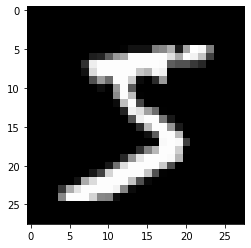

In [95]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.squeeze(0), cmap='gray')
print('Label:', label)

In [96]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [97]:
batch_size=128

In [98]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's visualize a batch of data in a grid using the make_grid function from torchvision

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Image Shape: torch.Size([128, 1, 28, 28])


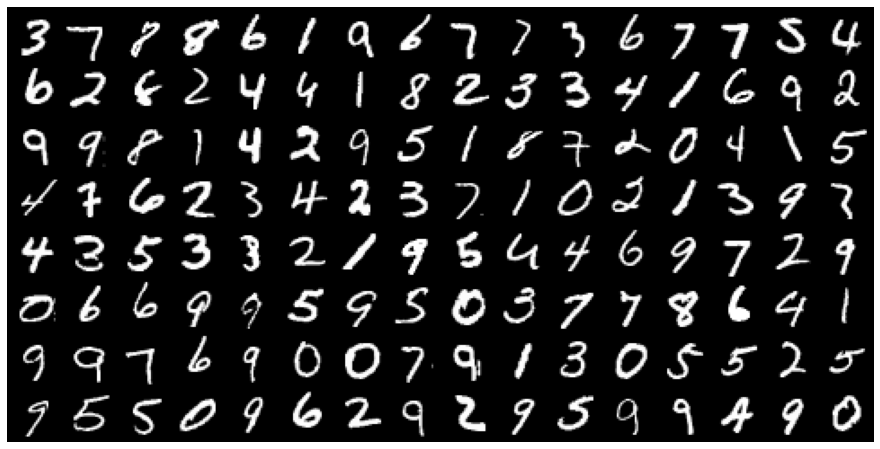

In [99]:
for images, _ in train_dl:
    print('Image Shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

We will use one hidden layer and one output layer to make NN and activation functions between them. We'll see how hidden layer and AFs helps to find non-linear relationship between inputs and output.
First, let's create a batch of inputs tensors. We'll flatten the 1x28x28 images into vectors of size 784, so they can be passed into an nn.Linear object.

In [100]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Next, let's create a `nn.Linear` object, which will serve as our _hidden_ layer. We'll set the size of the output from the hidden layer to 32. This number can be increased or decreased to change the _learning capacity_ of the model.

In [101]:
input_size = inputs.shape[-1]
hidden_size = 64

In [102]:
layer1 = nn.Linear(input_size, hidden_size)

In [103]:
inputs.shape

torch.Size([128, 784])

In [104]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 64])


In [105]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 64])

In [106]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula relu(x) = max(0,x) i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

In [107]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Let's apply the activation function to layer1_outputs and verify that negative values were replaced with 0.

In [108]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.7439053058624268
min(relu_outputs): 0.0


Define Output layer with size = 10

In [109]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [110]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


Calculate the loss from output

In [111]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3161, grad_fn=<NllLossBackward>)

In [112]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [113]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

#Extend the nn.Module Classe to define the model

In [153]:
input_size = 784 # Flattened images of vector size of 784
h1_size = 64 # Add First hidden layer with ouputs of 64
h2_size = 64 # Add Second hidden layer with ouputs of 64
num_classes = 10 # Add Output layer with target classes of 10

In [154]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [155]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, h1_size, h2_size, out_size):
        super().__init__()
        # hidden layer 1
        self.linear1 = nn.Linear(in_size, h1_size)
        # hidden layer 2
        self.linear2 = nn.Linear(h1_size, h2_size)
        # output layer
        self.linear3 = nn.Linear(h2_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out_h1 = self.linear1(xb)
        # Apply activation function
        out_af1 = F.relu(out_h1)
        # Get intermediate outputs using hidden layer 2
        out_h2 = self.linear2(out_af1)
        # Apply activation function
        out_af2 = F.relu(out_h2)
        # Get predictions using output layer
        out = self.linear3(out_af2)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [156]:
model = MnistModel(input_size, h1_size, h2_size, out_size=num_classes)

Let's run the model using some sample set of images

In [118]:
for images, labels in train_dl:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss: 2.307321786880493
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0904,  0.0219, -0.1306,  0.0685, -0.1057, -0.0453, -0.1441, -0.1404,
         -0.0337, -0.1118],
        [-0.0944,  0.0308, -0.0708,  0.0537, -0.1605, -0.0244, -0.1650, -0.0709,
         -0.0355, -0.1069]])


#Using GPU
As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks.

In [157]:
torch.cuda.is_available()

True

In [158]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [159]:
device = get_default_device()
device

device(type='cuda')

In [160]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [161]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
cuda:0


In [162]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [163]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [164]:
for xb, yb in val_dl:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


xb.device: cuda:0
yb: tensor([9, 7, 3, 9, 6, 6, 0, 4, 9, 1, 1, 4, 6, 6, 8, 9, 8, 6, 6, 6, 3, 0, 1, 2,
        9, 3, 7, 0, 6, 6, 2, 3, 9, 6, 7, 4, 0, 8, 1, 2, 3, 5, 5, 3, 4, 9, 4, 3,
        8, 1, 1, 0, 6, 1, 7, 5, 2, 9, 4, 1, 7, 8, 6, 3, 2, 5, 2, 5, 0, 2, 6, 0,
        2, 1, 1, 1, 6, 2, 3, 2, 2, 4, 4, 0, 5, 4, 3, 4, 3, 3, 3, 0, 5, 2, 7, 6,
        7, 3, 5, 0, 5, 9, 8, 2, 0, 9, 0, 1, 0, 6, 3, 1, 1, 7, 8, 3, 0, 3, 1, 6,
        9, 7, 3, 3, 8, 7, 7, 2, 5, 2, 2, 5, 3, 4, 2, 6, 3, 2, 6, 5, 7, 4, 3, 0,
        6, 7, 8, 2, 1, 7, 0, 2, 3, 8, 4, 9, 5, 9, 5, 9, 0, 7, 7, 7, 3, 5, 2, 1,
        5, 8, 7, 0, 1, 7, 7, 4, 5, 0, 0, 4, 2, 2, 6, 1, 4, 1, 2, 3, 5, 9, 0, 0,
        8, 9, 5, 3, 8, 8, 6, 8, 1, 1, 2, 0, 6, 4, 5, 0, 3, 9, 6, 6, 3, 6, 6, 2,
        6, 4, 4, 3, 9, 5, 3, 7, 0, 4, 6, 0, 9, 6, 9, 0, 0, 9, 0, 1, 7, 2, 2, 2,
        9, 4, 1, 4, 3, 5, 2, 6, 3, 1, 8, 9, 3, 1, 6, 2], device='cuda:0')


In [165]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [166]:
# Model (on GPU)
model = MnistModel(input_size, h1_size, h2_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [167]:
history = [evaluate(model, val_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.09335937350988388, 'val_loss': 2.306551694869995}]

In [169]:
history += fit(5, 0.5, model, train_dl, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.0959, val_acc: 0.9700
Epoch [1], val_loss: 0.0920, val_acc: 0.9722
Epoch [2], val_loss: 0.0944, val_acc: 0.9718
Epoch [3], val_loss: 0.0999, val_acc: 0.9692
Epoch [4], val_loss: 0.1122, val_acc: 0.9696


In [170]:
history += fit(5, 0.1, model, train_dl, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.0782, val_acc: 0.9778
Epoch [1], val_loss: 0.0799, val_acc: 0.9775
Epoch [2], val_loss: 0.0808, val_acc: 0.9777
Epoch [3], val_loss: 0.0806, val_acc: 0.9787
Epoch [4], val_loss: 0.0803, val_acc: 0.9780


In [171]:
history += fit(5, 0.1, model, train_dl, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.0801, val_acc: 0.9780
Epoch [1], val_loss: 0.0819, val_acc: 0.9779
Epoch [2], val_loss: 0.0844, val_acc: 0.9780
Epoch [3], val_loss: 0.0847, val_acc: 0.9782
Epoch [4], val_loss: 0.0843, val_acc: 0.9784


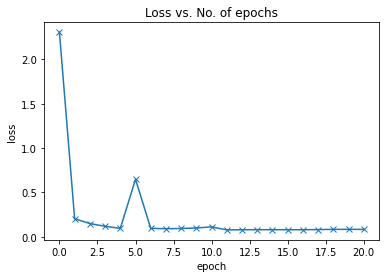

In [172]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

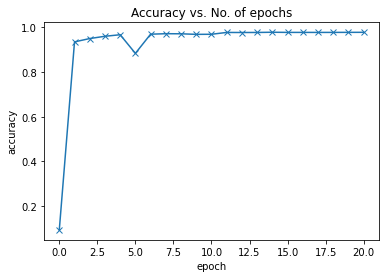

In [173]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

#Testing with individual images
While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the ToTensor transform.

In [174]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

Let's define a helper function predict_image, which returns the predicted label for a single image tensor.

In [175]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


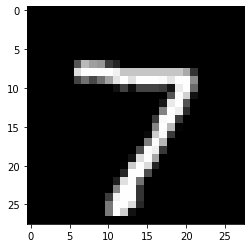

In [176]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


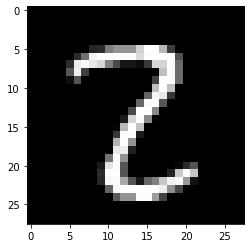

In [177]:
 img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 1 , Predicted: 1


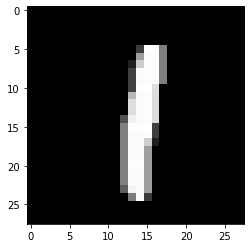

In [183]:
img, label = test_dataset[1834]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [184]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.9776366949081421, 'val_loss': 0.08246668428182602}